# Linear Least-Squares Fitting

In the following program we will explore linear least-squares fitting, with and without uncertainties.

John Moustakas  
Fall 2023

#### Import the packages we need.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Specify some settings to make our plots look "pretty".

In [2]:
sns.set(context='notebook', font_scale=1.6, style='whitegrid')
%matplotlib inline

#### Write a little function to generate some fake data: a linear relationship with scatter.

Set the random "seed" so our results are reproducible.

In [3]:
seed = 1

In [4]:
def linear_fake_data(slope=0.7, intercept=1.3, scatter=0.5, npts=100, seed=None):
    """Simple function to generate some fake data drawn from a line.

    Args:
        slope (float): slope of the line, defaults to 0.7
        intercept (float): y-intercept, defaults to 1.3
        scatter (float): scatter in the generated data, defaults to 0.5
        npts (int): number of random points to generate, defaults to 100
        seed (int): random seed, defaults to None
        
    Returns:
        xval (numpy.ndarray): array of x-values
        yval (numpy.ndarray): corresponding array of y-values
        yerr (numpy.ndarray): corresponding array of y-uncertainties
        truecoeff (list): 2-element list of coefficients.
    
    """
    rand = np.random.RandomState(seed=seed)

    truecoeff = [slope, intercept] # NB: the order matters!        

    xval = rand.uniform(0, 10, npts)
    yval = np.polyval(truecoeff, xval)
    yerr = rand.normal(0.0, scatter, npts)
    yval += yerr        # same as yval = yval + yerr

    yerr = np.abs(yerr) # uncertainties can't be negative!
    assert(np.all(yerr >= 0))

    return xval, yval, yerr, truecoeff

In [5]:
xval, yval, yerr, truecoeff = linear_fake_data()

#### Write a simple little function to create a plot...and then run it!

In [6]:
def simple_make_plot(xdata, ydata, yunc):
    """Simple function to create a scatterplot with uncertainties."""
    plt.errorbar(xdata, ydata, yunc, fmt='s', color='g', label='Data')
    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.legend(loc='best')

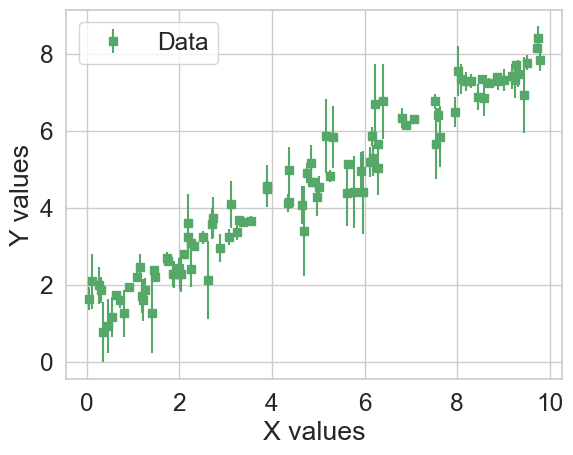

In [7]:
simple_make_plot(xval, yval, yerr)

#### Now let's determine the best-fitting line and overplot it!

In [8]:
def simple_bestfit_line(xdata, ydata, order=1):
    """Fit a linear relationship to input data without uncertainties."""
    coeff = np.polyfit(xdata, ydata, order)
    return coeff

In [9]:
bestcoeff = simple_bestfit_line(xval, yval)
print(f'Input coefficients: slope={truecoeff[0]}, intercept={truecoeff[1]}')
print(f'Best-fitting coefficients: slope={bestcoeff[0]:.4f}, intercept={bestcoeff[1]:.4f}')

Input coefficients: slope=0.7, intercept=1.3
Best-fitting coefficients: slope=0.6896, intercept=1.2515


#### But what about the uncertainties? To take those into account, we need to use the covariance matrix.

In [10]:
def bestfit_line(xdata, ydata, yuncertainty, order=1):
    coeff, cov = np.polyfit(xdata, ydata, order, w=1/yuncertainty, cov='unscaled')
    coeff_err = np.sqrt(np.diag(cov))
    return coeff, coeff_err

In [11]:
bestcoeff, bestcoeff_err = bestfit_line(xval, yval, yerr, order=1)
print(f'Input coefficients: slope={truecoeff[0]}, intercept={truecoeff[1]}')
print(f'Best-fitting coefficients: slope={bestcoeff[0]:.4f}+/-{bestcoeff_err[0]:.4f}, intercept={bestcoeff[1]:.4f}+/-{bestcoeff_err[1]:.4f}')

Input coefficients: slope=0.7, intercept=1.3
Best-fitting coefficients: slope=0.6986+/-0.0020, intercept=1.3032+/-0.0033


#### Let's update our plotting function to have a little more control...and then run it!

In [12]:
 def make_linear_plot(xdata, ydata, yunc, coeff=None, coeff_err=None):
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.errorbar(xdata, ydata, yunc, fmt='s', color='g', label='Data',
                capsize=3, capthick=2, markersize=10, markeredgecolor='k')
    ax.set_xlabel('X values')
    ax.set_ylabel('Y values')
    if coeff is not None:
        if coeff_err is not None:
            label = r'$m={:.4f}\pm{:.4f}$, $b={:.4f}\pm{:.4f}$'.format(
                coeff[0], coeff_err[0], coeff[1], coeff_err[1])
        else:
            label = 'm={:.4f}, b={:.4f}'.format(coeff[0], coeff[1])
                
        ax.plot(xdata, np.polyval(coeff, xdata), ls='--', lw=2,
                color='red', label=label, zorder=10)
    ax.legend(loc='upper left')    

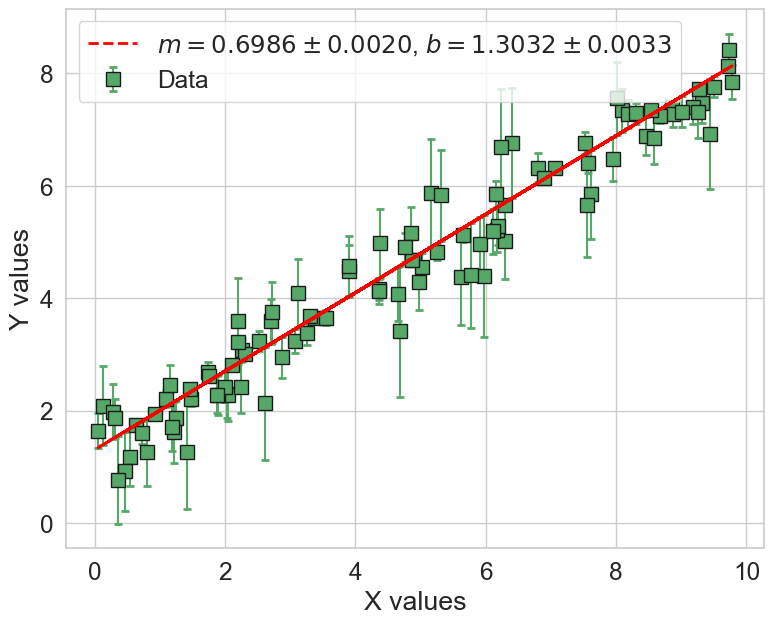

In [13]:
make_linear_plot(xval, yval, yerr, coeff=bestcoeff, coeff_err=bestcoeff_err)

#### Writing and reading the data is very straightforward.

In [14]:
outfile = 'example-data.txt'
data = np.vstack((xval, yval, yerr)).T
print(f'Writing {outfile}')
np.savetxt(outfile, data, header='xval yval yerr')

Writing example-data.txt


In [15]:
print(f'Reading {outfile}')
xdata, ydata, yunc = np.loadtxt(outfile, unpack=True)
assert(np.all(xdata == xval))

Reading example-data.txt


#### Let's go a little deeper a create a _polynomial_ (e.g., quadratic) fake dataset.

In [16]:
def fake_data(order=2, scatter=0.5, xmin=0, xmax=10, npts=100, seed=None):
    """Simple function to generate some fake data drawn from a polynomial.

    Args:
        order (int): polynomial order, defaults to 0.7
        scatter (float): scatter in the generated data, defaults to 0.5
        xmin (float): minimum x-value, defaults to 0
        xmax (float): maximum x-value, defaults to 100
        npts (int): number of random points to generate, defaults to 100
        seed (int): random seed, defaults to None
        
    Returns:
        xval (numpy.ndarray): array of x-values
        yval (numpy.ndarray): corresponding array of y-values
        yerr (numpy.ndarray): corresponding array of y-uncertainties
        truecoeff (list): true coefficients
    
    """
    rand = np.random.RandomState(seed=seed)
    truecoeff = rand.uniform(low=-1, high=+1, size=order+1)

    xval = rand.uniform(xmin, xmax, npts)
    yval = np.polyval(truecoeff, xval)
    yerr = rand.normal(0.0, scatter, npts)
    yval += yerr        # same as yval = yval + yerr

    yerr = np.abs(yerr) # uncertainties can't be negative!
    assert(np.all(yerr >= 0))

    return xval, yval, yerr, truecoeff

In [17]:
xx, yy, yyerr, polycoeff = fake_data(order=3, scatter=0.5, xmax=5, npts=100, seed=seed)

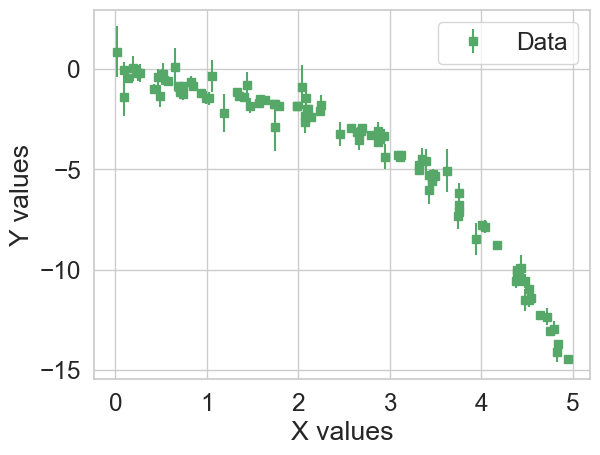

In [18]:
simple_make_plot(xx, yy, yyerr)

#### What happens if we fit a straight line to this dataset?

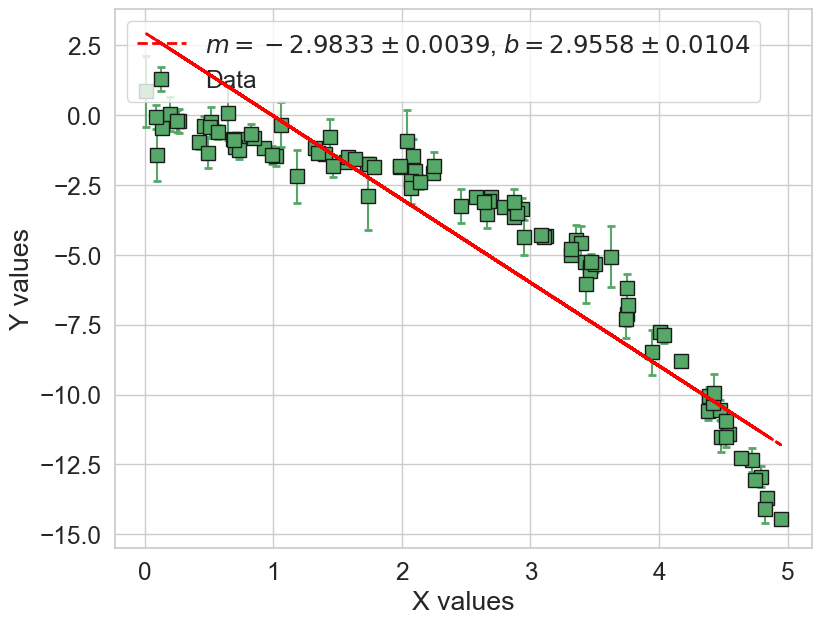

In [19]:
coeff, coeff_err = bestfit_line(xx, yy, yyerr, order=1)
make_linear_plot(xx, yy, yyerr, coeff=coeff, coeff_err=coeff_err)

#### To determine if we need to model our data with a higher order, we need to examine the _residuals_.

In [20]:
def make_plot(xdata, ydata, yunc, coeff=None, plot_residuals=False):

    if plot_residuals and coeff is not None:
        resid = ydata - np.polyval(coeff, xdata) # data minus model
        
        fig, ax = plt.subplots(2, 1, figsize=(8, 7), sharex=True, gridspec_kw={'height_ratios': [1, 0.4]})
        ax[0].errorbar(xdata, ydata, yunc, fmt='s', color='g', label='Data',
                       capsize=3, capthick=2, markersize=10, markeredgecolor='k')
        ax[0].plot(xdata, np.polyval(coeff, xdata), ls='--', lw=2,
                   color='red', label='Model', zorder=10)     
        
        ax[1].errorbar(xdata, resid, yunc, fmt='s', color='g', label='Data',
                       capsize=3, capthick=2, markersize=10, markeredgecolor='k')
        ax[1].axhline(y=0, color='red', ls='-', lw=2, zorder=10)
        ax[0].set_ylabel('Y values')        
        ax[1].set_ylabel('Residuals')
        ax[1].set_xlabel('X values')
        fig.subplots_adjust(hspace=0.05)
    else:
        fig, ax = plt.subplots(figsize=(9, 7))
        ax.errorbar(xdata, ydata, yunc, fmt='s', color='g', label='Data',
                    capsize=3, capthick=2, markersize=10, markeredgecolor='k')
        ax.set_xlabel('X values')
        ax.set_ylabel('Y values')
        if coeff is not None:
            ax.plot(xdata, np.polyval(coeff, xdata), ls='--', lw=2,
                    color='red', label=label, zorder=10)     
        ax.legend(loc='upper left')    

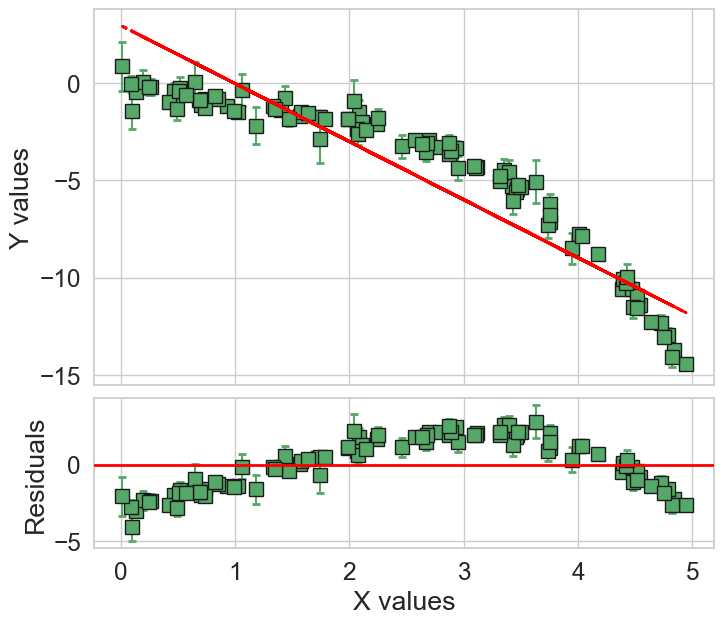

In [21]:
make_plot(xx, yy, yyerr, coeff=coeff, plot_residuals=True)